# LSTM Stock Price Prediction
Predict next-day close prices using LSTM neural networks

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Load and Preview Data
df = pd.read_csv('raw_data/stock_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['symbol', 'timestamp']).reset_index(drop=True)
print(f"Shape: {df.shape}, Symbols: {df['symbol'].nunique()}")
df.head()

Shape: (250167, 10), Symbols: 1008


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,index
0,A,2025-01-08 05:00:00+00:00,137.68,137.68,135.630,137.00,1684573.0,19948.0,137.068421,NaN
1,A,2025-01-10 05:00:00+00:00,134.75,140.14,134.709,137.47,1369875.0,25383.0,137.592663,NaN
2,A,2025-01-13 05:00:00+00:00,137.22,142.82,137.000,141.95,1561959.0,28739.0,141.776934,NaN
3,A,2025-01-14 05:00:00+00:00,142.00,145.38,140.150,143.43,2445434.0,36636.0,143.373405,NaN
4,A,2025-01-15 05:00:00+00:00,144.14,146.50,138.680,142.23,2328643.0,35076.0,142.841548,NaN


In [13]:
# Cell 3: Configuration
SEQUENCE_LENGTH = 30  # Days of history to use
FEATURES = ['open', 'high', 'low', 'close', 'volume']
TARGET = 'close'
TRAIN_SPLIT = 0.8
EPOCHS = 100
PATIENCE = 10  # Early stopping patience
DROPOUT = 0.3
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: mps


In [14]:
# Cell 4: Data Preparation Function (returns raw prices too for inverse transform)
def prepare_sequences(data, raw_data, seq_len, features, target):
    """Create sequences for LSTM training, also return raw target values"""
    X, y, y_raw = [], [], []
    feature_data = data[features].values
    raw_target = raw_data[target].values
    target_idx = features.index(target)
    
    for i in range(len(data) - seq_len):
        X.append(feature_data[i:i+seq_len])
        y.append(feature_data[i+seq_len, target_idx])
        y_raw.append(raw_target[i+seq_len])
    
    return np.array(X), np.array(y), np.array(y_raw)

In [15]:
# Cell 5: LSTM Model Definition (with configurable dropout)
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(self.dropout(lstm_out[:, -1, :]))

In [16]:
# Cell 6: Training Function with Early Stopping
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=0.001, patience=10):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    X_t = torch.FloatTensor(X_train).to(DEVICE)
    y_t = torch.FloatTensor(y_train).reshape(-1, 1).to(DEVICE)
    X_v = torch.FloatTensor(X_val).to(DEVICE)
    y_v = torch.FloatTensor(y_val).reshape(-1, 1).to(DEVICE)
    
    best_val_loss, patience_counter, best_state = float('inf'), 0, None
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(0, len(X_t), batch_size):
            batch_X, batch_y = X_t[i:i+batch_size], y_t[i:i+batch_size]
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation & early stopping
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_v), y_v).item()
        
        if val_loss < best_val_loss:
            best_val_loss, patience_counter = val_loss, 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train: {total_loss:.4f}, Val: {val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_state)
    return model

In [17]:
# Cell 7: Process All Symbols and Store Results
results = {}
scalers = {}
models = {}

# Select top 5 symbols by data count for demo (adjust as needed)
top_symbols = df.groupby('symbol').size().nlargest(5).index.tolist()
print(f"Training on symbols: {top_symbols}")

Training on symbols: ['A', 'AA', 'AAL', 'AAON', 'AAPL']


In [18]:
# Cell 8: Train Models for Each Symbol (stores raw prices for proper evaluation)
for symbol in top_symbols:
    print(f"\n{'='*50}\nTraining: {symbol}")
    sym_data = df[df['symbol'] == symbol].copy()
    raw_data = sym_data.copy()  # Keep unscaled version
    
    if len(sym_data) < SEQUENCE_LENGTH + 20:
        print(f"Skipping {symbol}: insufficient data")
        continue
    
    # Scale features
    scaler = MinMaxScaler()
    sym_data[FEATURES] = scaler.fit_transform(sym_data[FEATURES])
    scalers[symbol] = scaler
    
    # Create sequences (with raw prices)
    X, y, y_raw = prepare_sequences(sym_data, raw_data, SEQUENCE_LENGTH, FEATURES, TARGET)
    split = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    y_raw_test = y_raw[split:]
    
    # Split train into train/val (90/10)
    val_split = int(len(X_train) * 0.9)
    X_tr, X_val = X_train[:val_split], X_train[val_split:]
    y_tr, y_val = y_train[:val_split], y_train[val_split:]
    
    # Train model with early stopping
    model = LSTMPredictor(len(FEATURES), dropout=DROPOUT).to(DEVICE)
    train_model(model, X_tr, y_tr, X_val, y_val, epochs=EPOCHS, patience=PATIENCE)
    models[symbol] = model
    
    # Evaluate - inverse transform predictions to actual prices
    model.eval()
    with torch.no_grad():
        preds_scaled = model(torch.FloatTensor(X_test).to(DEVICE)).cpu().numpy().flatten()
    
    # Proper inverse transform for predictions
    dummy = np.zeros((len(preds_scaled), len(FEATURES)))
    dummy[:, FEATURES.index(TARGET)] = preds_scaled
    preds_actual = scaler.inverse_transform(dummy)[:, FEATURES.index(TARGET)]
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_raw_test, preds_actual)
    mae = mean_absolute_error(y_raw_test, preds_actual)
    
    # Directional accuracy
    actual_dir = np.diff(y_raw_test) > 0
    pred_dir = np.diff(preds_actual) > 0
    dir_acc = (actual_dir == pred_dir).mean() * 100
    
    results[symbol] = {
        'mse': mse, 'mae': mae, 'dir_acc': dir_acc,
        'y_test': y_raw_test, 'preds': preds_actual
    }
    print(f"{symbol} - MSE: {mse:.2f}, MAE: ${mae:.2f}, Direction Acc: {dir_acc:.1f}%")


Training: A
Epoch 20/100, Train: 0.0277, Val: 0.1508
Early stopping at epoch 22
A - MSE: 556.29, MAE: $23.19, Direction Acc: 44.2%

Training: AA
Epoch 20/100, Train: 0.0083, Val: 0.0317
Epoch 40/100, Train: 0.0069, Val: 0.0261
Epoch 60/100, Train: 0.0060, Val: 0.0211
Epoch 80/100, Train: 0.0050, Val: 0.0203
Epoch 100/100, Train: 0.0046, Val: 0.0158
AA - MSE: 120.47, MAE: $9.87, Direction Acc: 41.9%

Training: AAL
Early stopping at epoch 12
AAL - MSE: 10.48, MAE: $3.11, Direction Acc: 53.5%

Training: AAON
Epoch 20/100, Train: 0.0388, Val: 0.0523
Epoch 40/100, Train: 0.0231, Val: 0.0376
Epoch 60/100, Train: 0.0193, Val: 0.0344
Early stopping at epoch 64
AAON - MSE: 49.85, MAE: $5.40, Direction Acc: 51.2%

Training: AAPL
Epoch 20/100, Train: 0.0394, Val: 0.1949
Early stopping at epoch 25
AAPL - MSE: 3267.55, MAE: $56.98, Direction Acc: 48.8%


In [19]:
# Cell 9: Results Summary (with directional accuracy)
results_df = pd.DataFrame({
    k: {'MSE': v['mse'], 'MAE ($)': v['mae'], 'Direction Acc (%)': v['dir_acc']} 
    for k, v in results.items()
}).T
print("\nModel Performance Summary:")
results_df


Model Performance Summary:


,MSE,MAE ($),Direction Acc (%)
A,556.287688,23.186276,44.186047
AA,120.472733,9.872833,41.860465
AAL,10.476911,3.113001,53.488372
AAON,49.845732,5.404005,51.162791
AAPL,3267.549141,56.980497,48.837209


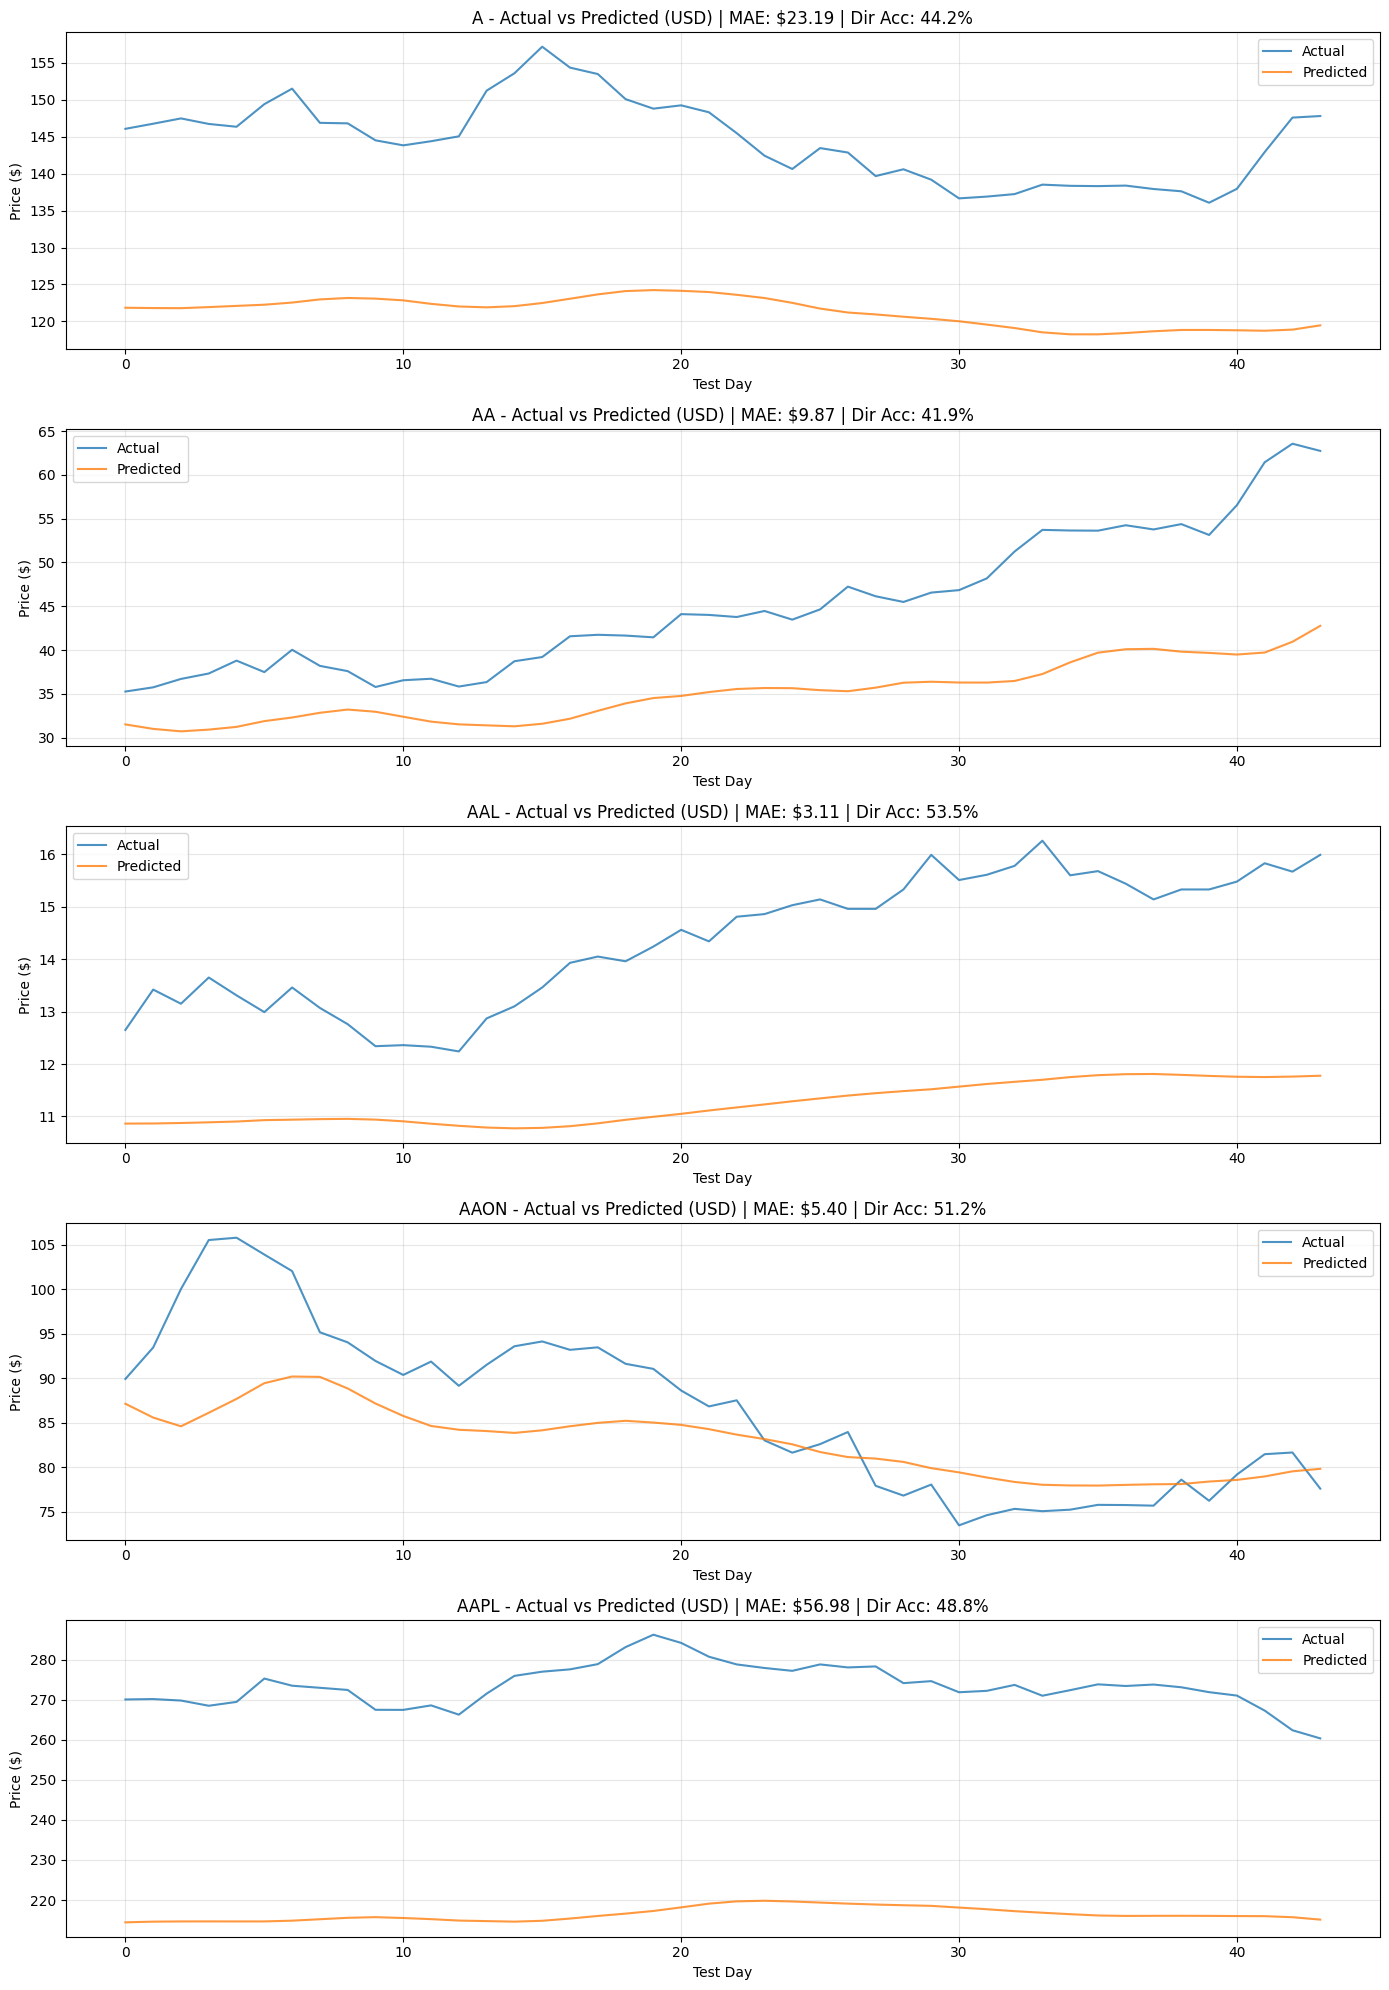

In [20]:
# Cell 10: Visualize Predictions (Actual Prices, not normalized)
fig, axes = plt.subplots(len(results), 1, figsize=(14, 4*len(results)))
if len(results) == 1:
    axes = [axes]

for ax, (symbol, res) in zip(axes, results.items()):
    ax.plot(res['y_test'], label='Actual', alpha=0.8, linewidth=1.5)
    ax.plot(res['preds'], label='Predicted', alpha=0.8, linewidth=1.5)
    ax.set_title(f'{symbol} - Actual vs Predicted (USD) | MAE: ${res["mae"]:.2f} | Dir Acc: {res["dir_acc"]:.1f}%')
    ax.set_ylabel('Price ($)')
    ax.set_xlabel('Test Day')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Cell 11: Predict Next Day Close (Fixed inverse scaling)
def predict_next_close(symbol, model, scaler, df, seq_len=SEQUENCE_LENGTH):
    """Predict next day's close price for a symbol"""
    sym_data = df[df['symbol'] == symbol].tail(seq_len).copy()
    sym_data_scaled = sym_data.copy()
    sym_data_scaled[FEATURES] = scaler.transform(sym_data[FEATURES])
    
    X = torch.FloatTensor(sym_data_scaled[FEATURES].values).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        pred_scaled = model(X).cpu().numpy()[0, 0]
    
    # Proper inverse transform
    dummy = np.zeros((1, len(FEATURES)))
    dummy[0, FEATURES.index(TARGET)] = pred_scaled
    pred_actual = scaler.inverse_transform(dummy)[0, FEATURES.index(TARGET)]
    return pred_actual

# Demo prediction with direction
df_orig = pd.read_csv('raw_data/stock_data.csv')
print("Next Day Predictions:")
for symbol in list(models.keys()):
    pred = predict_next_close(symbol, models[symbol], scalers[symbol], df_orig)
    last_close = df_orig[df_orig['symbol'] == symbol]['close'].iloc[-1]
    change = pred - last_close
    direction = "📈" if change > 0 else "📉"
    print(f"{symbol}: Last=${last_close:.2f} → Predicted=${pred:.2f} ({direction} {change:+.2f})")

Next Day Predictions:
A: Last=$147.81 → Predicted=$120.26 (📉 -27.55)
AA: Last=$62.74 → Predicted=$43.96 (📉 -18.78)
AAL: Last=$15.99 → Predicted=$11.80 (📉 -4.19)
AAON: Last=$77.61 → Predicted=$79.84 (📈 +2.23)
AAPL: Last=$260.33 → Predicted=$214.25 (📉 -46.08)


In [22]:
# Cell 12: Save Best Model
best_symbol = results_df['MSE'].idxmin()
torch.save(models[best_symbol].state_dict(), f'model_archive/lstm_{best_symbol}.pt')
print(f"Saved best model: {best_symbol} (MSE: {results_df.loc[best_symbol, 'MSE']:.6f})")

Saved best model: AAL (MSE: 10.476911)
